<center><h1>Unsupervised Clustering</h1></center>
    
<center>Comparison of different clustering algorithms on toy datasets</center>

The following notebook shows characteristics of different
clustering algorithms on datasets that are "interesting"
but still in 2D. With the exception of the last dataset,
the parameters of each of these dataset-algorithm pairs
has been tuned to produce good clustering results. Some
algorithms are more sensitive to parameter values than
others.

The last dataset is an example of a 'null' situation for
clustering: the data is homogeneous, and there is no good
clustering. For this example, the null dataset uses the
same parameters as the dataset in the row above it, which
represents a mismatch in the parameter values and the
data structure.

While these examples give some intuition about the
algorithms, this intuition might not apply to very high
dimensional data.>

## Import the libraries

In [ ]:
%matplotlib inline
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

## Generate the datasets

In [ ]:
# ============
# Generates datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

## Set up cluster parameters

In [ ]:
# ============
# Sets up cluster parameters
# ============
default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

## Fit algorithms for each dataset

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


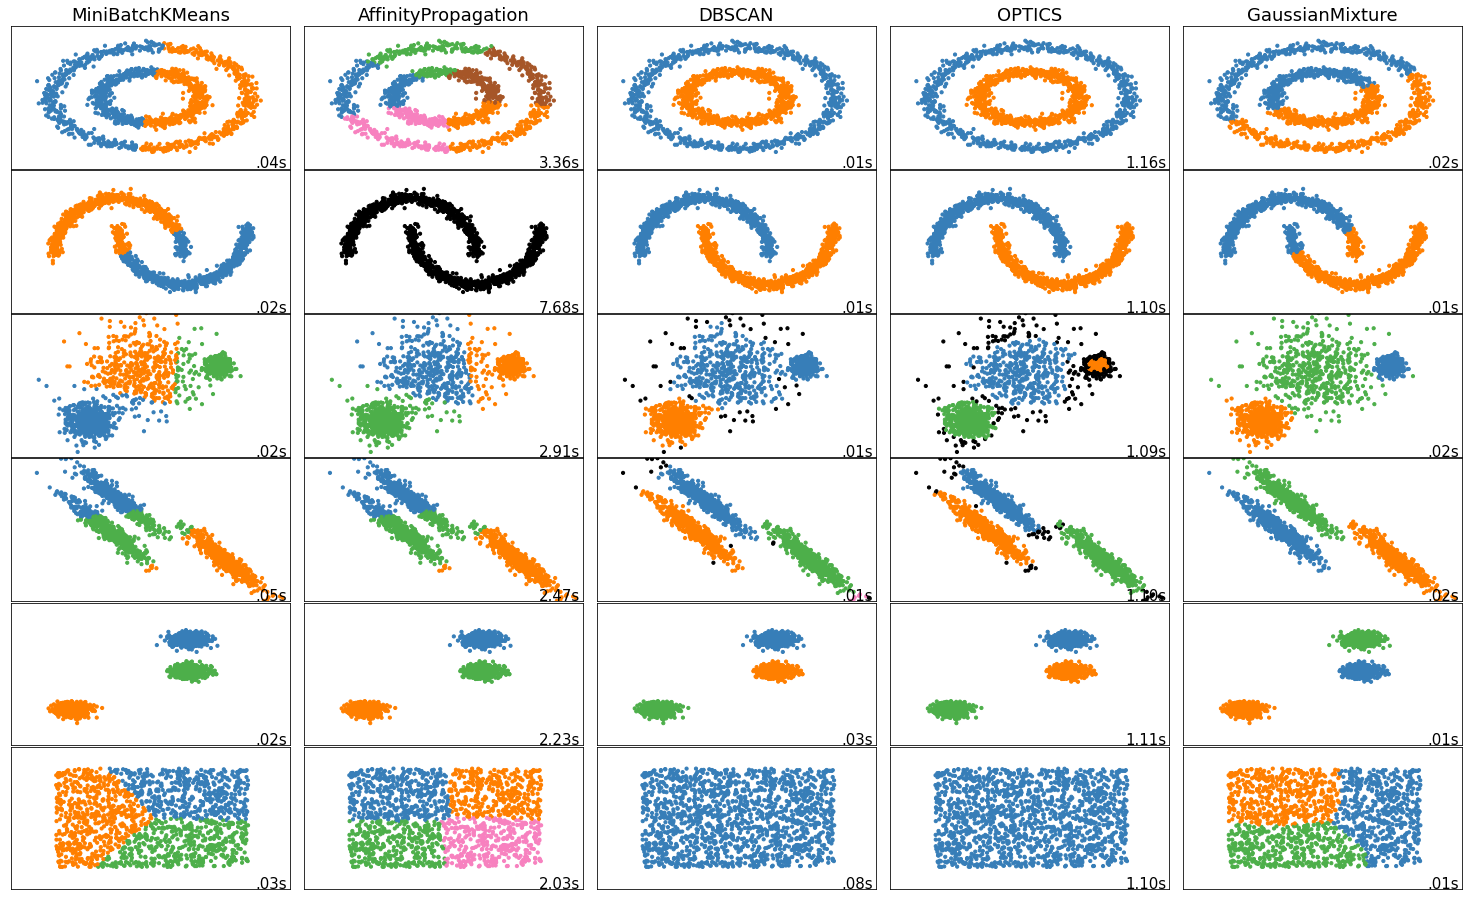

In [ ]:
# ============
# Sets up the upcoming plot figure
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)
plot_num = 1


# ============
# Loops over the list of dataset generated
# ============
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # ============
    # Sets up the parameters of the algorithms
    # according to the dataset currently in use
    # ============
    
    # updates parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalizes dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    
    # ============
    # Creates cluster objects
    # ============
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (('MiniBatchKMeans', two_means),
                             ('AffinityPropagation', affinity_propagation),
                             ('DBSCAN', dbscan),
                             ('OPTICS', optics),
                             ('GaussianMixture', gmm))

    
    # ============
    # Loops over the list of algorithms intantiated
    # ============
    for name, algorithm in clustering_algorithms:
        # ============
        # Measures the time taken by an algorithm
        # to fit the dataset -- Part 1/2
        # ============
        t0 = time.time()

        
        # ============
        # Performs the fitting
        # ============
        algorithm.fit(X)

        
        # ============
        # Measures the time taken by an algorithm
        # to fit the dataset -- Part 2/2
        # ============
        t1 = time.time()
        
        
        # ============
        # Performs the prediction on the dataset
        # ============
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

            
        # ============
        # Plots the fitted datasets
        # ============
        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        
        # Defines the colors of the different clusters
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # adds black color for outliers for DBSCAN/OPTICS algorithms
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

        
# ============
# Displays fitted datasets
# ============
plt.show()

# Comparison between the different type of clustering 

We have here different type of clustering method applied on different datasets. Those datasets have different shapes and here we want to compare the efficiecy of the method related to the shape of the datasets. 

After having listed the advantages and incovients of the methods, we will compare them globally. 

What is it important to question ourself before the compare ? 

* if the method is showing the outliers. this is important because we would want to delete these outliers. 
* we want to avoid overlapping. This can happen when there is not enough features settled. 
* the time processing is also important. Less it is,better it is. 
* also the position of the cluster must be respected. if we can clearly see a cluster but is composed of multiple colors then, the method is not correct. 

We have six datasets. 

What we supposed to have : 
1. two clusters : inner circle and out circle
2. one branch and the other one 
3. three different clusters 
4. three different clusters in stick
5. three different clusters in little bubbles
6. one big cluster in square 

Every of the method is supposed to have a minimal time of processing an be able to show outliers in order to limit the amoung of false prediction. In order to be utopicly efficient, the methods have to answer these demands. 


**MiniBatchKmeans** 

Time : really doog time processing (< 0.05 sec)

Outliers : not shown

Mistakes with datasets : excepts for the 5, the cluster are wrongly positioned 


**Affinity Propagation** 

Time : bad (< 1 sec)

Outliers : not shown (except 2, but too much)

Mistakes with datasets : too much features in the 1 and 6, and for 3, 4 the cluster are wrongly positionned 

**DBSCAN** 

Time : really good (> 0.09 sec)

Outliers : shown 

Mistakes with datasets : None

**Optics** 

Time : in between (around 1 sec) 

Outliers : shown

Mistakes with datasets : None

**Gaussians** 

Time : really good (>0.02 sec) 

Outliers : not shown

Mistakes with datasets : 1,2 the cluster are not well positionned, 6 too much features 

We can conclued that the best method would be the DBSCAN. The time proessing is one of he best one, the ouliers are shown and the method shows no mistakes by positionning the cluster. 